In [48]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [49]:
try:
    df = pd.read_csv("customer_shopping_data.csv")
except FileNotFoundError:
    print("Error: The file 'customer_shopping_data.csv' was not found. Please check the file path.")

df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [50]:
df.dropna(inplace = True)
df.drop(['invoice_no', 'customer_id', 'invoice_date'], axis = 1, inplace = True)

df['total_purchase'] = df['price'] * df['quantity']
df = df[(df['total_purchase'] >= 50) & (df['total_purchase'] <= 200)]
df.reset_index(drop = True, inplace = True)

df= pd.concat([df] * 5, ignore_index = True)

categorical_cols = ['gender', 'category', 'payment_method']
for col in categorical_cols:
    df[f"{col}_code"] = df[col].astype('category').cat.codes

df.head()

,gender,age,category,quantity,price,payment_method,shopping_mall,total_purchase,gender_code,category_code,payment_method_code
0,Male,65,Books,2,30.30,Debit Card,Metrocity,60.60,1,0,2
1,Male,51,Toys,2,71.68,Debit Card,Istinye Park,143.36,1,4,2
2,Male,67,Cosmetics,2,81.32,Credit Card,Metropol AVM,162.64,1,1,1
3,Female,41,Books,3,45.45,Cash,Istinye Park,136.35,0,0,0
4,Female,53,Cosmetics,2,81.32,Credit Card,Istinye Park,162.64,0,1,1


In [51]:
features = ['age'] + [f"{col}_code" for col in categorical_cols]
X = df[features]
y = df['total_purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_test = y_test.to_numpy() if hasattr(y_test, "to_numpy") else y_test

class_weights = compute_class_weight(
    'balanced',
    classes = np.unique(y_train),
    y = y_train
)
class_weights_dict = dict(enumerate(class_weights))

In [52]:
X_train

array([[ 0.56812948,  1.21895879,  0.0584957 , -0.98498931],
       [-1.51376057,  1.21895879,  1.74787104, -0.98498931],
       [ 0.36665625, -0.82037228,  0.0584957 , -0.98498931],
       ...,
       [-0.57355216,  1.21895879,  0.0584957 , -0.98498931],
       [ 1.23970692,  1.21895879,  0.90318337, -0.98498931],
       [-1.31228734,  1.21895879,  0.0584957 ,  0.31339872]])

In [53]:
y_train

array([ 83.68, 143.36,  83.68, ...,  83.68, 105.57, 130.75])

In [54]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU is set for TensorFlow.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU.")

GPU is set for TensorFlow.


In [55]:
model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='tanh'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs          = 25,
    batch_size      = 32,
    class_weight    = class_weights_dict,
    verbose         = 1,
    callbacks       = [lr_callback]
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Predict on the test set
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 11133.5918 - mae: 94.3193 - val_loss: 644.8968 - val_mae: 20.4158 - learning_rate: 0.0010
Epoch 2/25
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 760.7890 - mae: 23.2150 - val_loss: 644.6813 - val_mae: 20.2649 - learning_rate: 0.0010
Epoch 3/25
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 747.4100 - mae: 23.0060 - val_loss: 644.6729 - val_mae: 20.3002 - learning_rate: 0.0010
Epoch 4/25
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 739.6442 - mae: 22.8953 - val_loss: 644.7737 - val_mae: 20.6553 - learning_rate: 0.0010
Epoch 5/25
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 733.2797 - mae: 22.8398 - val_loss: 645.4880 - val_mae: 20.3870 - learning_rate: 0.0010
Epoch 6/25
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 730.0686 - mae: 22.8471 - val_loss: 644.7766 - val_mae: 20.3552 - learning_rate: 0.0010
Epoch 7/25
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 727.2588 - mae: 22.7542 - val_loss:

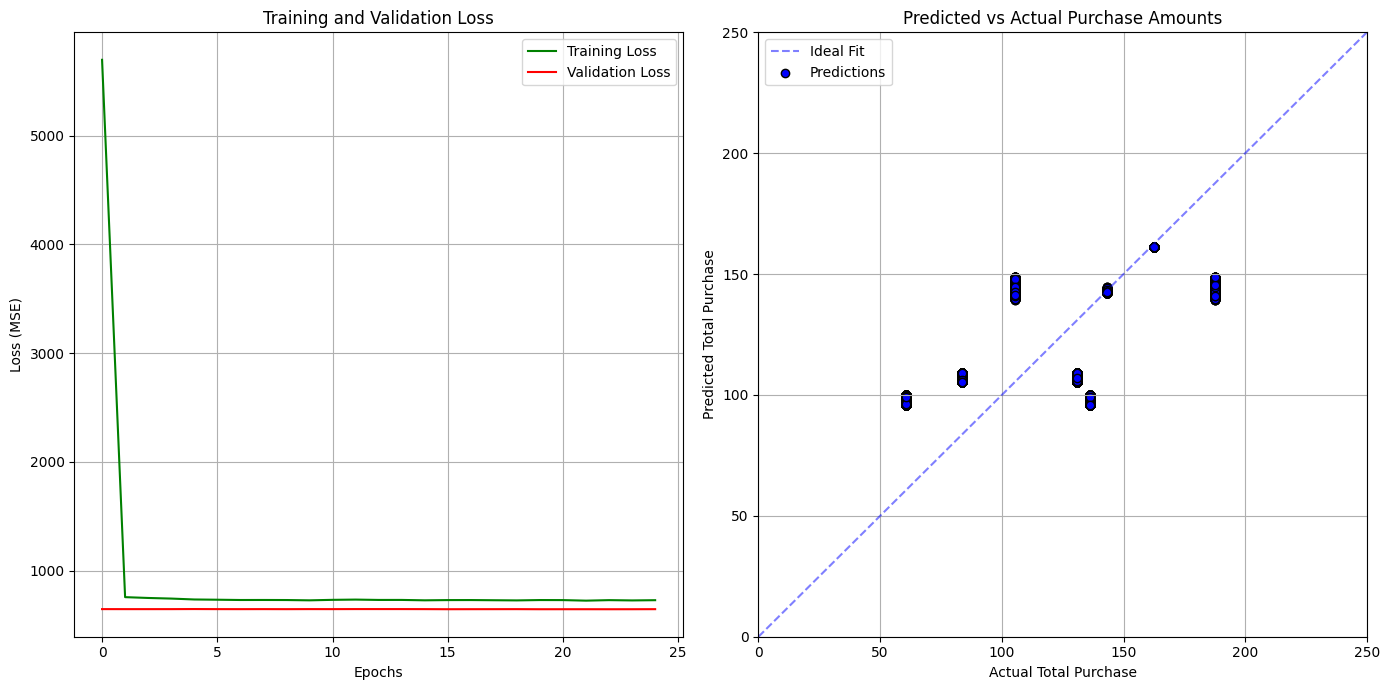

In [56]:
# Create a figure and two subplots in one row
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot training and validation loss on the first subplot
ax[0].plot(history.history['loss'], label='Training Loss', color='green')
ax[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].legend()
ax[0].grid(True)

# Plot predicted vs actual values on the second subplot
ax[1].plot([0, 250], [0, 250], color='blue', alpha=0.5, linestyle='--', label='Ideal Fit')  # Line within the range
ax[1].scatter(y_test, y_pred, color='blue', edgecolor='k', label='Predictions')
ax[1].set_xlim(0, 250)  # Set x-axis range
ax[1].set_ylim(0, 250)  # Set y-axis range
ax[1].set_title('Predicted vs Actual Purchase Amounts')
ax[1].set_xlabel('Actual Total Purchase')
ax[1].set_ylabel('Predicted Total Purchase')
ax[1].legend()
ax[1].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [57]:
# Prepare results in a DataFrame
test_results = pd.DataFrame({
    "Actual Total Purchase":    y_test,
    "Predicted Total Purchase": y_pred.flatten()
})

# Save the results to a CSV file for review
output_file = "complex_model_predicted_vs_actual.csv"
test_results.to_csv(output_file, index = False)
print(f"Results saved to {output_file}")

Results saved to complex_model_predicted_vs_actual.csv


In [58]:
# Save the entire model
model.save("customer_shopping_model.keras")

# Load the model later
# from tensorflow.keras.models import load_model
# loaded_model = load_model("my_model")